In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SPSA, GradientDescent
from qiskit_machine_learning.utils import algorithm_globals


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
import os

# Establece la GPU a usar (en este caso la GPU #1)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
train = pd.read_csv("train_QNN3.csv")
val = pd.read_csv("val_QNN3.csv")
test = pd.read_csv("test_QNN3.csv")

In [5]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

X_val = val.drop(columns=['category'])
y_val = val['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category'])
y_test= test['category']

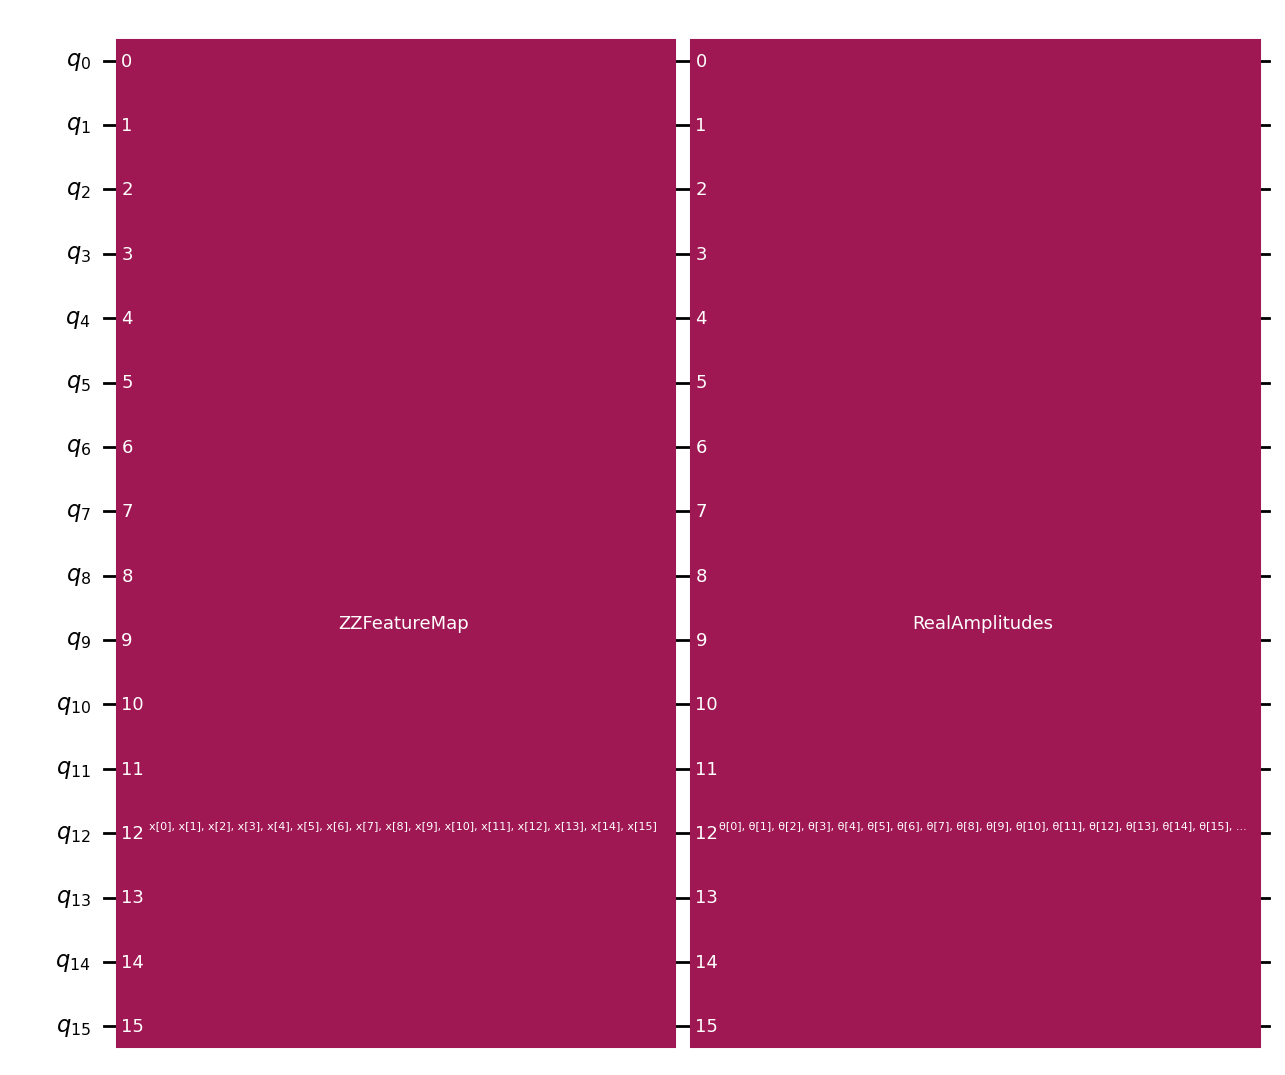

In [6]:
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import QNNCircuit

num_qubits = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
qc.draw("mpl")

In [7]:
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient

from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN


backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
sampler_gradient = ParamShiftSamplerGradient(sampler=sampler, pass_manager=pass_manager)
isa_qc = pass_manager.run(qc)

sampler_qnn = SamplerQNN(
    circuit=isa_qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    #interpret=parity,
    #output_shape=10,
    sampler=sampler,
    gradient=sampler_gradient,
)

In [8]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, 
    optimizer=COBYLA(maxiter=2),
    #callback=callback_graph
)

In [ ]:
sampler_classifier.fit(X_train, y_train)

# VARIATIONAL QUANTUM CLASSIFIER

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train = pd.read_csv("train_QNN3.csv")
test = pd.read_csv("test_QNN3.csv")

In [6]:
porcentaje_mantener = 0.1

train = train.groupby('category').sample(frac=porcentaje_mantener)
test = test.groupby('category').sample(frac=porcentaje_mantener)


In [7]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['proto','category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['proto','category'])
y_test= test['category']

In [8]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical

#Codificacion de etiquetas (Numéricas)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Convertir las etiquetas codificadas a codificación one-hot (10 columnas por muestras)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=10)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=10)

2025-05-06 09:55:44.476961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746525344.492845 2833465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746525344.498681 2833465 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 09:55:44.519321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
history = []

def vqc_callback(weights, objective_value):
    history.append((weights.copy(), objective_value))
    print(f"Current loss: {objective_value:.6f}")


In [9]:
history = []

def ADAM_callback(step, params, value):
    print(f"Step {step}: f(x) = {value:.5f}, params = {params}")
    history.append((params.copy(), value))


In [9]:
history = []

def SPSA_callback(nfev, params, value, step_size, accepted):
    print(f"Eval {nfev:03d} | f(x) = {value:.5f} | step = {step_size:.5f} | accepted = {accepted}")
    history.append((params.copy(), value, step_size, accepted))


In [10]:
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_machine_learning.algorithms.classifiers import  VQC
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap

num_qubits = X_train.shape[1]

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)

backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
#sampler_gradient = ParamShiftSamplerGradient(sampler=sampler, pass_manager=pass_manager)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=ADAM(maxiter=1, amsgrad=True),
    #callback=SPSA_callback,
    sampler=sampler,
    pass_manager=pass_manager,
    output_shape=10
)

In [ ]:
import time
start_time = time.time()
vqc.fit(X_train, y_train_one_hot)
end_time = time.time()
print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

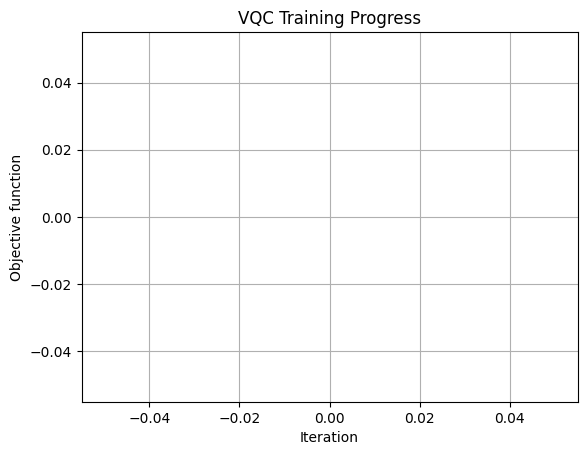

In [12]:
# Por ejemplo, plotear la evolución del loss
import matplotlib.pyplot as plt

losses = [entry[1] for entry in history]
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.title("VQC Training Progress")
plt.grid(True)
plt.show()

In [13]:
y_pred_proba = vqc.predict(X_test)
#6min

In [14]:
y_pred = np.argmax(y_pred_proba, axis=1)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_proba, y_test_one_hot)

0.10188087774294671

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test_encoded)

0.1171571696931747

In [ ]:
vqc.score(X_train, y_train_one_hot)
#20min

0.11810382616319118

In [ ]:
print("Predicciones del clasificador:")
print(accuracy_score(y_pred, y_test))

Predicciones del clasificador:
0.1
